In [1]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

# Exploratory Data Analysis: Data & Analytics Job Market

**Research Question:** What does the job market look like for Business Analytics, Data Science, and ML professionals in 2024?

**What we're Looking into:**
1. **Who's hiring?** → Top industries (barplot) and companies (treemap)
2. **What roles exist?** → Job titles within our occupation categories
3. **What do they say?** → Word cloud from job descriptions
4. **What skills do they want?** → Radar charts for each occupation + software skills barplot
5. **What drives salary?** → Salary by remote work type
6. **Where are jobs posted?** → Source types analysis

Each insight builds toward our ML modeling decisions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
from wordcloud import WordCloud
import re

pd.set_option('display.max_columns', None)

df = pd.read_csv('data/lightcast_cleaned.csv')
df['POSTED'] = pd.to_datetime(df['POSTED'])



print(f"Dataset: {len(df):,} job postings")
print(f"Date range: {df['POSTED'].min().strftime('%b %Y')} - {df['POSTED'].max().strftime('%b %Y')}")
print(f"Occupations: {df['LOT_V6_OCCUPATION_NAME'].nunique()}")

Dataset: 47,513 job postings
Date range: May 2024 - Sep 2024
Occupations: 4


## Who's Hiring?

In [3]:
# Top 5 Industries - Horizontal Bar Plot
industry_counts = df['NAICS_2022_2_NAME'].value_counts().head(5)

# Shorten long industry names
industry_short = {
    'Professional, Scientific, and Technical Services': 'Professional Services',
    'Administrative and Support and Waste Management and Remediation Services': 'Admin & Support Services',
    'Management of Companies and Enterprises': 'Management & Enterprises',
    'Finance and Insurance': 'Finance & Insurance',
    'Information': 'Information',
    'Health Care and Social Assistance': 'Healthcare & Social',
    'Manufacturing': 'Manufacturing',
    'Retail Trade': 'Retail Trade',
    'Educational Services': 'Educational Services',
    'Wholesale Trade': 'Wholesale Trade'
}
short_names = [industry_short.get(name, name[:30]) for name in industry_counts.index]

fig = go.Figure()
fig.add_trace(go.Bar(
    y=short_names,
    x=industry_counts.values,
    orientation='h',
    marker_color=px.colors.qualitative.Set2[:5],
    text=industry_counts.values,
    textposition='outside'
))

fig.update_layout(
    title='Top 5 Industries Hiring Data Professionals',
    xaxis_title='Number of Job Postings',
    yaxis={'categoryorder': 'total ascending'},
    template='plotly_white',
    height=400,
    margin=dict(l=180, r=100),
    xaxis=dict(range=[0, industry_counts.values.max() * 1.15])
)
fig.write_image('figures/top_industries.png', scale=2)
fig.show()

# Top 10 Companies - Vertical Bar Plot with colors
company_counts = df['COMPANY_NAME'].value_counts().head(10).reset_index()
company_counts.columns = ['Company', 'Postings']

fig2 = go.Figure()
fig2.add_trace(go.Bar(
    x=company_counts['Company'],
    y=company_counts['Postings'],
    marker_color=px.colors.qualitative.Plotly[:10],
    text=company_counts['Postings'],
    textposition='outside'
))

fig2.update_layout(
    title='Top 10 Companies Hiring Data Professionals',
    xaxis_title='Company',
    yaxis_title='Number of Job Postings',
    template='plotly_white',
    height=550,
    xaxis_tickangle=-45,
    margin=dict(b=150, t=80),
    yaxis=dict(range=[0, company_counts['Postings'].max() * 1.15])
)
fig2.write_image('figures/top_companies.png', scale=2)
fig2.show()

print("\nTop 10 Companies by Job Postings:")
for i, row in company_counts.iterrows():
    pct = row['Postings'] / len(df) * 100
    print(f"  {i+1}. {row['Company']}: {row['Postings']:,} postings ({pct:.1f}%)")


Top 10 Companies by Job Postings:
  1. Deloitte: 2,271 postings (4.8%)
  2. Accenture: 1,316 postings (2.8%)
  3. PricewaterhouseCoopers: 697 postings (1.5%)
  4. Insight Global: 362 postings (0.8%)
  5. Cardinal Health: 346 postings (0.7%)
  6. Chewy: 319 postings (0.7%)
  7. Smx Corporation Limited: 317 postings (0.7%)
  8. Oracle: 311 postings (0.7%)
  9. Robert Half: 309 postings (0.7%)
  10. Randstad: 285 postings (0.6%)


## What Roles can you Go for?

In [4]:
# Top 5 Job Titles per Occupation Category
occupations = df['LOT_V6_OCCUPATION_NAME'].unique()

# Shorten occupation names for subplot titles
occ_short_titles = {
    'Data / Data Mining Analyst': 'Data/Data Mining',
    'Business Intelligence Analyst': 'Business Intelligence', 
    'Business / Management Analyst': 'Business/Management',
    'Market Research Analyst': 'Market Research'
}

colors = {'Data / Data Mining Analyst': '#1f77b4', 
          'Business Intelligence Analyst': '#ff7f0e', 
          'Business / Management Analyst': '#2ca02c', 
          'Market Research Analyst': '#d62728'}

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[occ_short_titles.get(occ, occ) for occ in occupations],
    horizontal_spacing=0.35,
    vertical_spacing=0.30
)

for idx, occ in enumerate(occupations):
    row = idx // 2 + 1
    col = idx % 2 + 1
    
    df_occ = df[df['LOT_V6_OCCUPATION_NAME'] == occ]
    df_occ = df_occ[~df_occ['TITLE_NAME'].str.contains('Unclassified', case=False, na=False)]
    top_titles = df_occ['TITLE_NAME'].value_counts().head(5)
    
    # Shorten titles
    truncated_titles = [t[:20] + '...' if len(t) > 20 else t for t in top_titles.index]
    
    fig.add_trace(
        go.Bar(
            y=truncated_titles,
            x=top_titles.values,
            orientation='h',
            marker_color=colors.get(occ, '#636EFA'),
            text=top_titles.values,
            textposition='outside',
            name=occ,
            showlegend=False
        ),
        row=row, col=col
    )
    
    # Set individual x-axis range based on each subplot's max value
    subplot_max = top_titles.values.max()
    fig.update_xaxes(range=[0, subplot_max * 1.25], title_text="Count", row=row, col=col)
    fig.update_yaxes(categoryorder='total ascending', tickfont=dict(size=9), row=row, col=col)

fig.update_layout(
    title_text='Top 5 Job Titles per Occupation Category',
    height=700,
    template='plotly_white',
    margin=dict(l=160, r=60, t=80, b=40)
)
fig.write_image('figures/job_titles_by_occupation.png', scale=2)
fig.show()

print("\nPostings per Occupation:")
for occ, count in df['LOT_V6_OCCUPATION_NAME'].value_counts().items():
    print(f"  • {occ}: {count:,} ({count/len(df)*100:.1f}%)")


Postings per Occupation:
  • Data / Data Mining Analyst: 22,672 (47.7%)
  • Business Intelligence Analyst: 21,640 (45.5%)
  • Business / Management Analyst: 3,083 (6.5%)
  • Market Research Analyst: 118 (0.2%)


## Wordcloud of Job Descriptions

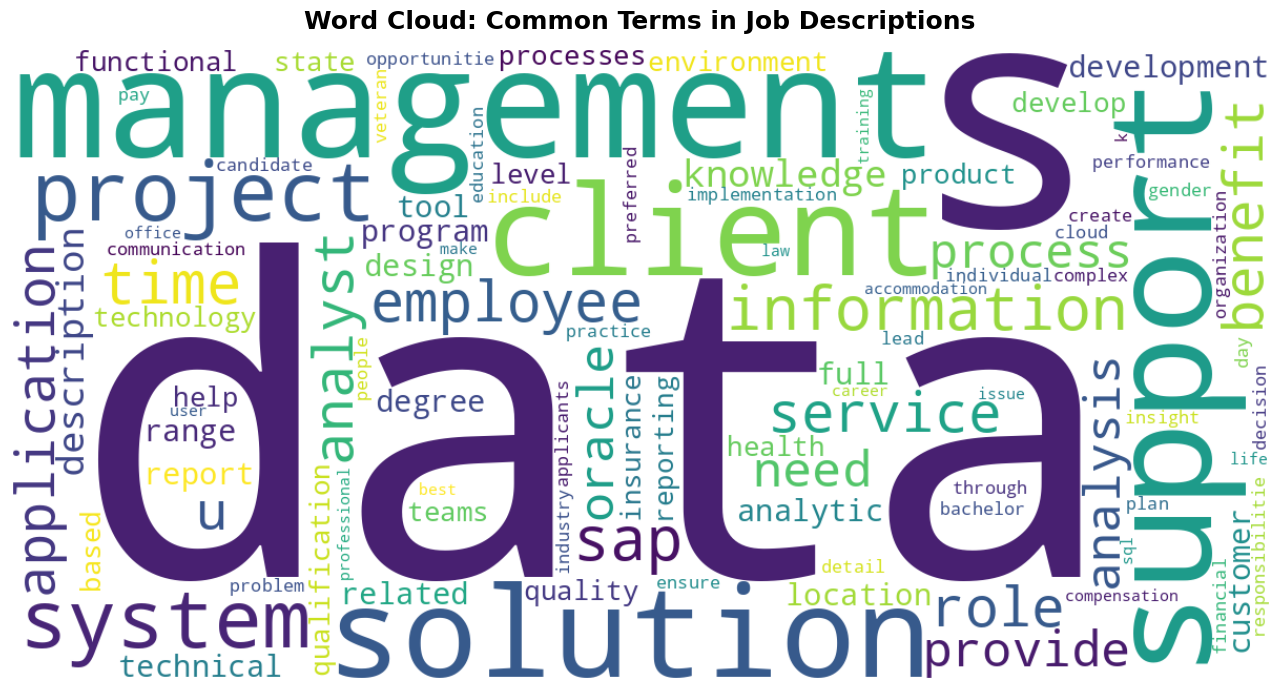

Word cloud generated from 3,000 sampled job postings


In [5]:
# Using a sample of 3000 rows to prevent crashes

custom_stopwords = {
    'the', 'and', 'to', 'of', 'a', 'in', 'for', 'is', 'on', 'that', 'by', 'this',
    'with', 'are', 'be', 'as', 'at', 'from', 'or', 'an', 'will', 'your', 'you',
    'we', 'our', 'have', 'has', 'it', 'their', 'all', 'can', 'been', 'would',
    'who', 'more', 'if', 'about', 'which', 'when', 'what', 'into', 'also',
    'may', 'other', 'its', 'than', 'should', 'such', 'any', 'these', 'only',
    'new', 'well', 'them', 'they', 'but', 'not', 'do', 'up', 'out', 'so',
    'job', 'position', 'apply', 'applicant', 'employer', 'employment',
    'equal', 'opportunity', 'eeo', 'affirmative', 'action', 'disability',
    'race', 'color', 'religion', 'sex', 'national', 'origin', 'age',
    'status', 'protected', 'discrimination', 'including', 'without', 'regard',
    'com', 'www', 'http', 'https', 'click', 'here', 'learn', 'please', 'contact',
    'must', 'work', 'working', 'experience', 'years', 'year', 'required',
    'requirements', 'skills', 'ability', 'strong', 'excellent', 'good',
    'team', 'company', 'business', 'including', 'within', 'across', 'using'
}

df_sample = df.sample(n=min(3000, len(df)), random_state=42)
body_text = ' '.join(df_sample['BODY'].dropna().astype(str).tolist())

body_text = re.sub(r'[^a-zA-Z\s]', ' ', body_text.lower())
body_text = re.sub(r'\s+', ' ', body_text)

wordcloud = WordCloud(
    width=1200, 
    height=600,
    background_color='white',
    stopwords=custom_stopwords,
    max_words=100,
    colormap='viridis',
    collocations=False,
    random_state=42
).generate(body_text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: Common Terms in Job Descriptions', fontsize=18, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('figures/job_description_wordcloud.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"Word cloud generated from {len(df_sample):,} sampled job postings")

## Skills to Look For

In [6]:
def extract_skills(skills_series):
    all_skills = []
    for skills in skills_series.dropna():
        if isinstance(skills, str) and skills not in ['Not Listed', '']:
            all_skills.extend([s.strip() for s in skills.split(',')])
    return Counter(all_skills)

# Shorten skill names for better display
def shorten_skill(skill):
    replacements = {
        'SQL (Programming Language)': 'SQL',
        'Microsoft Excel': 'Excel',
        'Microsoft Power BI': 'Power BI',
        'Computer Science': 'Computer Sci',
        'Problem Solving': 'Problem Solving',
        'Data Visualization': 'Data Viz',
        'Business Intelligence': 'Business Intel',
        'Project Management': 'Project Mgmt',
        'Data Management': 'Data Mgmt',
        'Business Development': 'Business Dev',
        'Customer Service': 'Customer Svc',
        'Marketing Strategy': 'Mktg Strategy',
        'Market Research': 'Market Research',
        'Statistical Analysis': 'Statistics'
    }
    return replacements.get(skill, skill[:14] + '..' if len(skill) > 14 else skill)

occ_short = {
    'Business Intelligence Analyst': 'Business Intelligence',
    'Data / Data Mining Analyst': 'Data/Data Mining',
    'Business / Management Analyst': 'Business/Management',
    'Market Research Analyst': 'Market Research'
}

colors_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
occupations = df['LOT_V6_OCCUPATION_NAME'].unique().tolist()

# Get top 8 skills for EACH occupation separately
skill_data = {}
for occ in occupations:
    df_occ = df[df['LOT_V6_OCCUPATION_NAME'] == occ]
    occ_skills = extract_skills(df_occ['SKILLS_NAME'])
    top_8 = occ_skills.most_common(8)
    total = len(df_occ)
    skill_data[occ] = {
        'skills': [s[0] for s in top_8],
        'values': [(s[1] / total * 100) for s in top_8]
    }

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'polar'}, {'type': 'polar'}],
           [{'type': 'polar'}, {'type': 'polar'}]],
    subplot_titles=[occ_short.get(occ, occ) for occ in occupations],
    vertical_spacing=0.18,
    horizontal_spacing=0.12
)

for idx, occ in enumerate(occupations):
    row = idx // 2 + 1
    col = idx % 2 + 1
    
    skills = skill_data[occ]['skills']
    values = skill_data[occ]['values']
    
    # Shorten labels and close the polygon
    short_labels = [shorten_skill(s) for s in skills]
    values_closed = values + [values[0]]
    labels_closed = short_labels + [short_labels[0]]
    
    fig.add_trace(
        go.Scatterpolar(
            r=values_closed,
            theta=labels_closed,
            fill='toself',
            name=occ_short.get(occ, occ),
            line_color=colors_list[idx],
            fillcolor=colors_list[idx],
            opacity=0.5,
            showlegend=False
        ),
        row=row, col=col
    )

# Update polar subplots
fig.update_polars(
    radialaxis=dict(
        visible=True,
        tickfont=dict(size=9),
        range=[0, 85]
    ),
    angularaxis=dict(
        tickfont=dict(size=10),
        rotation=90,
        direction='clockwise'
    )
)

fig.update_layout(
    title=dict(
        text='Top 8 Skills by Occupation (Each with Own Top Skills)',
        font=dict(size=16),
        y=0.98
    ),
    height=750,
    template='plotly_white',
    margin=dict(t=80, b=30, l=60, r=60)
)

# Adjust subplot title positions
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12, color='#333')
    annotation['y'] = annotation['y'] + 0.02

fig.write_image('figures/skills_radar_by_occupation.png', scale=2)
fig.show()

# Print the top skills for each occupation
print("\nTop 8 Skills by Occupation:")
for occ in occupations:
    print(f"\n{occ_short.get(occ, occ)}:")
    for skill, val in zip(skill_data[occ]['skills'], skill_data[occ]['values']):
        print(f"  • {skill}: {val:.1f}%")

# Software skills - Horizontal Bar Chart
software_counts = extract_skills(df['SOFTWARE_SKILLS_NAME'])
top_software = pd.DataFrame(software_counts.most_common(12), columns=['Software', 'Count'])
top_software['Percentage'] = (top_software['Count'] / len(df) * 100).round(1)

fig2 = go.Figure()
fig2.add_trace(go.Bar(
    y=top_software['Software'],
    x=top_software['Percentage'],
    orientation='h',
    marker_color='mediumpurple',
    text=[f"{p}%" for p in top_software['Percentage']],
    textposition='outside'
))

fig2.update_layout(
    title='Top 12 Software/Technical Skills (% of Postings)',
    xaxis_title='% of Job Postings',
    yaxis={'categoryorder': 'total ascending'},
    template='plotly_white',
    height=450,
    margin=dict(r=80)
)
fig2.write_image('figures/software_skills.png', scale=2)
fig2.show()


Top 8 Skills by Occupation:

Business Intelligence:
  • Communication: 42.9%
  • SAP Applications: 36.5%
  • Management: 35.1%
  • Business Process: 29.0%
  • Business Requirements: 27.5%
  • Problem Solving: 25.0%
  • Finance: 24.5%
  • Consulting: 22.7%

Data/Data Mining:
  • Data Analysis: 76.4%
  • SQL (Programming Language): 51.7%
  • Communication: 45.1%
  • Management: 33.7%
  • Python (Programming Language): 31.5%
  • Tableau (Business Intelligence Software): 30.7%
  • Microsoft Excel: 28.3%
  • Dashboard: 27.5%

Business/Management:
  • Communication: 51.4%
  • Management: 38.1%
  • Operations: 35.6%
  • Leadership: 34.9%
  • Microsoft Excel: 31.2%
  • Problem Solving: 30.1%
  • Presentations: 29.5%
  • Project Management: 28.6%

Market Research:
  • Customer Relationship Management: 83.1%
  • Business Process: 45.8%
  • Communication: 41.5%
  • Business Requirements: 41.5%
  • Salesforce: 40.7%
  • Project Management: 40.7%
  • Sales: 39.8%
  • Problem Solving: 38.1%


## How does Remote Work Type affect Salary?

In [7]:
# Salary Analysis - Violin Plot by Remote Work Type and Occupation
df_remote = df[df['REMOTE_TYPE_NAME'] != 'Not Specified'].copy()

fig = px.violin(
    df_remote,
    x='REMOTE_TYPE_NAME',
    y='SALARY',
    color='LOT_V6_OCCUPATION_NAME',
    box=True,
    title='Salary Distribution by Remote Work Type and Occupation',
    labels={
        'REMOTE_TYPE_NAME': 'Remote Work Type',
        'SALARY': 'Annual Salary ($)',
        'LOT_V6_OCCUPATION_NAME': 'Occupation'
    }
)
fig.update_layout(
    template='plotly_white',
    height=500,
    legend=dict(orientation='h', yanchor='bottom', y=-0.3)
)
fig.write_image('figures/salary_by_remote.png', scale=2)
fig.show()

print("\nSalary Statistics by Remote Type:")
salary_stats = df_remote.groupby('REMOTE_TYPE_NAME')['SALARY'].agg(['count', 'median', 'mean', 'std']).round(0)
salary_stats.columns = ['Count', 'Median', 'Mean', 'Std Dev']
salary_stats['Median'] = salary_stats['Median'].apply(lambda x: f"${x:,.0f}")
salary_stats['Mean'] = salary_stats['Mean'].apply(lambda x: f"${x:,.0f}")
salary_stats['Std Dev'] = salary_stats['Std Dev'].apply(lambda x: f"${x:,.0f}")
print(salary_stats)


Salary Statistics by Remote Type:
                  Count   Median      Mean  Std Dev
REMOTE_TYPE_NAME                                   
Hybrid Remote      1482  $96,008  $105,086  $28,885
Not Remote          688  $98,800  $104,989  $27,900
Remote             7950  $99,700  $109,444  $29,127


## Where can you apply for these Jobs?

In [8]:
def extract_sources(source_series):
    all_sources = []
    for sources in source_series.dropna():
        if isinstance(sources, str):
            all_sources.extend([s.strip() for s in sources.split(',') if s.strip()])
    return Counter(all_sources)

source_counts = extract_sources(df['SOURCE_TYPES'])

cleaned_counts = {}
for source, count in source_counts.items():
    if source == 'NONE' or source == '':
        continue
    elif source == 'Job intermediary':
        cleaned_counts['Recruiter'] = cleaned_counts.get('Recruiter', 0) + count
    elif source =='FreeJobBoard':
        cleaned_counts['Job Board'] = cleaned_counts.get('Job Board', 0) + count
    else:
        cleaned_counts[source] = cleaned_counts.get(source, 0) + count

top_sources = pd.DataFrame(list(cleaned_counts.items()), columns=['Source', 'Count'])
top_sources = top_sources.sort_values('Count', ascending=False).head(10).reset_index(drop=True)

# Calculate percentage based on total source mentions (not total jobs)
total_source_mentions = top_sources['Count'].sum()
top_sources['Percentage'] = (top_sources['Count'] / total_source_mentions * 100).round(1)

fig = px.treemap(
    top_sources,
    path=['Source'],
    values='Count',
    title='Job Posting Sources Distribution',
    color='Count',
    color_continuous_scale='Blues'
)
fig.update_layout(template='plotly_white', height=500)
fig.update_traces(textinfo='label+value+percent root', textfont_size=14)
fig.write_image('figures/source_types.png', scale=2)
fig.show()

print(f"\nJob Posting Sources (Total mentions: {total_source_mentions:,}):")
for i, row in top_sources.iterrows():
    print(f"  {i+1}. {row['Source']}: {row['Count']:,} ({row['Percentage']}%)")


Job Posting Sources (Total mentions: 57,491):
  1. Job Board: 39,645 (69.0%)
  2. Company: 13,668 (23.8%)
  3. Recruiter: 2,792 (4.9%)
  4. Government: 865 (1.5%)
  5. Education: 521 (0.9%)


## EDA Conclusion

Our exploratory analysis of **47,000+ job postings** reveals key insights for data analytics professionals:

**Industry & Companies:** Industry & Companies: Professional Services leads with 17,600+ postings, followed by Admin & Support Services, Finance & Insurance, Manufacturing, and Information. Deloitte dominates hiring (2,271 postings, 4.8%), followed by Accenture, PwC, and Insight Global—consulting firms are the primary employers.

**Job Roles**: Data/Data Mining Analysts (47.7%) and Business Intelligence Analysts (45.5%) make up over 93% of postings. Business/Management Analysts account for 6.5%, while Market Research Analysts represent only 0.2%.

**Skills Demand**: Each occupation has distinct skill requirements:

- Data Analysts: Data Analysis (76%), SQL (52%), Python (32%), Tableau (31%)
- Business Intelligence: Communication (43%), SAP (37%), Management (35%)
- Business/Management: Communication (51%), Management (38%), Operations (36%)
- Market Research: CRM (83%), Business Process (46%), Salesforce (41%)

**Online VS Offline :** Remote Jobs pay much more higher than hybrid and online jobs for all four occupations. This could tell us that the trend COVID-19 instilled among companies of hiring workers online is slowly dying and infact occupations like Market research analyst have zero online job mode.

**Job Sources:** Job postings often appear on multiple platforms - Job Boards lead with 39,645 postings (83.4% of jobs), Company websites list 13,668 (28.8%), and Recruiters post 2,792 (5.9%). 

